In [862]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [863]:
file_name = "BTC_1_year_data.csv"

stop_loss_buffer = 0.07
lookback_period = 15

In [864]:
df = pd.read_csv(file_name, index_col=0, parse_dates=True)
df.head()

,open,high,low,close,volume
close_time,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001


In [865]:
starting_capital = df["close"].iloc[0]

In [866]:
df["Close"] = df["close"]

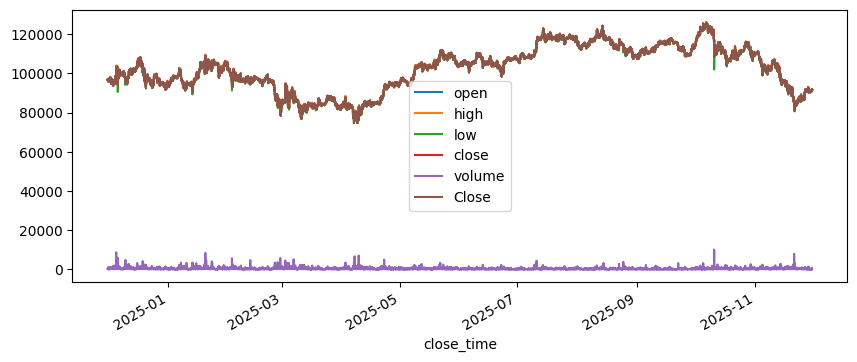

In [867]:
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(ax=ax)
plt.show()

#### Creating the strategy

In [868]:
def compute_support_resistance(df, window=20, shift_levels=1):
    df = df.copy()
    #Rolling low and high of closing prices
    df["support"] = df["Close"].rolling(window=window, min_periods=1).min()
    df["resistance"]= df["Close"].rolling(window=window, min_periods=1).max()

    #Shift levels forward to avaoid using future information

    df["support"] = df["support"].shift(shift_levels)
    df["resistance"] = df["resistance"].shift(shift_levels)
    return df

df = compute_support_resistance(df, window=lookback_period, shift_levels=1)

In [869]:
df

,open,high,low,close,volume,Close,support,resistance
close_time,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.50
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.50
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.50
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.50
...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,91682.73,91048.78,91851.19
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,91554.20,91048.78,91851.19
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,91359.92,91048.78,91851.19


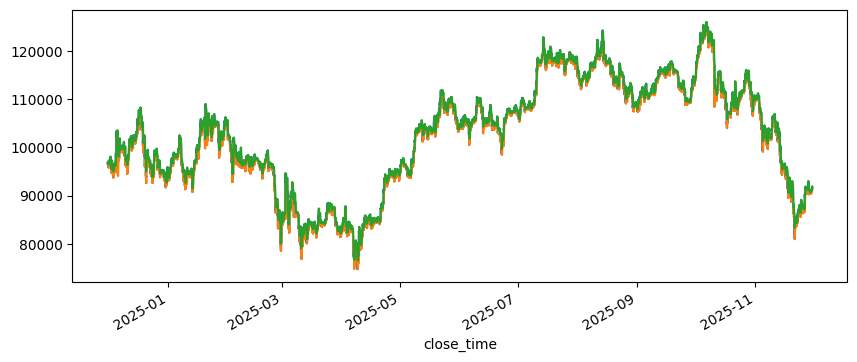

In [870]:
fig, ax = plt.subplots(figsize=(10, 4))
df["Close"].plot(ax=ax)
df["support"].plot(ax=ax)
df["resistance"].plot(ax=ax)
plt.show()

##### Generating Entry Signal (Fakeout Entry)

In [871]:
def generate_entry_signal(df):
    """
    Create raw entry signal:
    We only mark the moment price touches or goes below support.
    ML will later decide whether it's a good long entry.
    """
    df = df.copy()
    
    # event: price touches or goes <= support
    df['entry_raw'] = (df['Close'] <= df['support']) & df['support'].notna()

    return df


In [872]:
df = generate_entry_signal(df)
df.head()

,open,high,low,close,volume,Close,support,resistance,entry_raw
close_time,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.5,True
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.5,False
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.5,False
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.5,True


##### Generating Exit Signal

In [873]:
def generate_exit_signal(df):
    """ 
    Create exit signal.
    Exit when close touches or exceeds rolling resistance.
    """
    df = df.copy()
    df["exit_raw"] = (df["Close"] >= df["resistance"]) & df["resistance"].notna()
    return df

In [874]:
df = generate_exit_signal(df)
df.head()

,open,high,low,close,volume,Close,support,resistance,entry_raw,exit_raw
close_time,,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False,False
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.5,True,False
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.5,False,False
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.5,False,False
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.5,True,False


##### Build Positions (State machine Logic)

    - We create a position column
    - Position = 1 -> we are in a long trade
    - Position = 0 -> we are flat(waiting for next entry)

The Logic - 

- If we are flat and entry_raw == True -> Enter long
- If we are in a long and exit_raw == True -> Exit
- If we are in a long and SL hits, -> Exit
- While in a trade, ingore all new entry_raw signals

This ensures -

- No double entries
- No rebuying inside an open Trade
- Clear start and end of every trade
- Takes real stop loss into account

#### Creating features for filteration using Machine learning model

In [875]:
df["close_log_return"] = np.log(df["Close"]/df["Close"].shift())

In [876]:
df = df.copy()
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)
df = df.drop(columns=["close_log_return"])
df["close_log_return_lag_3"]=df["close_log_return_lag_3"].fillna(value=0)
 

In [877]:
df.head()

,open,high,low,close,volume,Close,support,resistance,entry_raw,exit_raw,close_log_return_lag_3
close_time,,,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False,False,0.000000
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.5,True,False,0.000000
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.5,False,False,0.000000
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.5,False,False,0.000000
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.5,True,False,-0.000261


#### Build Position V1

In [878]:
import joblib
model = joblib.load("logistic_model.pkl")


In [879]:
def build_position(
        df, sl_buffer=0.005,
        entry_col="entry_raw",
        exit_col="exit_raw"
):
    df = df.copy()
    threshold = 0.4992055

    pos = 0
    entry_price = None
    fixed_stop = None

    positions = []
    entry_prices = []
    exit_prices = []

    for i in range(len(df)):
        entry_signal = df[entry_col].iloc[i]
        exit_signal = df[exit_col].iloc[i]
        price = df["Close"].iloc[i]

        if pos == 0:
            # Only attempt entry when entry_signal is True
            if entry_signal:

                # ML filter
                x = df["close_log_return_lag_3"].iloc[i]
                x_input = np.array([[x]])

                # PROBABILITY OF CLASS 0 (correct index)
                proba_class0 = model.predict_proba(x_input)[0][1]

                model_signal = proba_class0 > threshold
                print(model_signal, proba_class0)

                # Enter only if ML AND rule-based entry both agree
                if model_signal:
                    pos = 1
                    entry_price = price
                    fixed_stop = entry_price * (1 - sl_buffer)

            current_exit_price = None

        else:
            # Only evaluate exit rules when inside a position
            stop_signal = price <= fixed_stop

            if exit_signal or stop_signal:
                pos = 0
                current_exit_price = price
                fixed_stop = None

                # DO NOT wipe out entry_price here
                # compute_strategy_returns() needs it
                # It is reset AFTER PnL is computed
            else:
                current_exit_price = None

        # record values
        positions.append(pos)
        entry_prices.append(entry_price if pos == 1 else entry_price)
        exit_prices.append(current_exit_price)

        # If exit happened at this candle, reset entry_price NEXT iteration
        if current_exit_price is not None:
            entry_price = None

    df["position"] = positions
    df["entry_price"] = entry_prices
    df["exit_price"] = exit_prices

    return df


In [880]:
df = build_position(df, stop_loss_buffer)
df.head()

True 0.49920593867545454
True 0.4992059558561997
True 0.4992059694024778
True 0.4992059131085218
True 0.49920597510700443
True 0.4992059402312537
True 0.4992059799031831
True 0.4992059348351038
True 0.49920590548487365
True 0.49920593758648596
True 0.49920594897602305
True 0.4992058339531261
True 0.4992059167459174
True 0.4992060185883557
True 0.4992059307211256
True 0.49920592178687373
True 0.49920594035893895
True 0.4992059604501281
True 0.49920584131318074
True 0.4992059189627953
True 0.4992058450712368
True 0.4992059658219577
True 0.49920596166985237
True 0.499205941481911
True 0.4992059945868497
True 0.4992059434148575
True 0.49920591085425375
True 0.49920591127479275
True 0.4992059159691863
True 0.4992059041628516
True 0.4992059784529845
True 0.4992059765370171
True 0.4992059114510135
True 0.4992059639389781
True 0.49920593511718886
True 0.4992059728021188
True 0.49920584420041303
True 0.49920592649806783
True 0.4992059314317877
True 0.4992059696910264
True 0.4992060198440042
Tru

,open,high,low,close,volume,Close,support,resistance,entry_raw,exit_raw,close_log_return_lag_3,position,entry_price,exit_price
close_time,,,,,,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False,False,0.000000,0,NaN,NaN
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.5,True,False,0.000000,1,96634.28,NaN
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.5,False,False,0.000000,1,96634.28,NaN
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.5,False,False,0.000000,1,96634.28,NaN
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.5,True,False,-0.000261,1,96634.28,NaN


##### Compute Strategy returns

In [881]:
def compute_strategy_returns(df, starting_capital=starting_capital):
    """
    Extremely simple loop-based PnL calculation.
    - No slippage
    - No fees
    - Uses recorded 'position'
    """

    df = df.copy()
    equity = starting_capital
    equity_list = [equity]

    entry_price = None

    for i in range(1, len(df)):
        pos_prev = df["position"].iloc[i-1]
        pos_now = df["position"].iloc[i]
        price_now = df["Close"].iloc[i]

        # Entry
        if pos_prev == 0 and pos_now == 1:
            entry_price = price_now

        # Exit
        if pos_prev == 1 and pos_now == 0:
            exit_price = price_now
            ret = (exit_price - entry_price) / entry_price
            equity *= (1 + ret)
            entry_price = None

        equity_list.append(equity)

    # Handle case where last trade never closed
    if df["position"].iloc[-1] == 1 and entry_price is not None:
        # Force close at final price
        final_price = df["Close"].iloc[-1]
        ret = (final_price - entry_price) / entry_price
        equity *= (1 + ret)
        equity_list[-1] = equity

    df["equity"] = equity_list
    df["cumulative_return"] = (df["equity"] / starting_capital) - 1

    return df


In [882]:
df= compute_strategy_returns(df, starting_capital)
df

,open,high,low,close,volume,Close,support,resistance,entry_raw,exit_raw,close_log_return_lag_3,position,entry_price,exit_price,equity,cumulative_return
close_time,,,,,,,,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False,False,0.000000,0,NaN,NaN,96659.500000,0.000000
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.50,True,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.50,False,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.50,False,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.50,True,False,-0.000261,1,96634.28,NaN,96659.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,91682.73,91048.78,91851.19,False,False,0.004175,0,NaN,NaN,102400.775549,0.059397
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,91554.20,91048.78,91851.19,False,False,-0.001771,0,NaN,NaN,102400.775549,0.059397
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,91359.92,91048.78,91851.19,False,False,0.000886,0,NaN,NaN,102400.775549,0.059397


In [883]:
import matplotlib.pyplot as plt

def plot_equity_vs_price(df):
    # Convert time series index into a column so plotting is simple
    df_simple = df.reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Now x-axis becomes simple integers: 0, 1, 2, ...
    ax.plot(df_simple.index, df_simple["Close"], label="Closing Price")
    ax.plot(df_simple.index, df_simple["equity"], label="Strategy Equity")

    # Title
    ax.set_title("Closing Price vs Strategy Equity Curve")

    # Labels
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

    # Legend
    ax.legend()

    plt.tight_layout()
    plt.show()


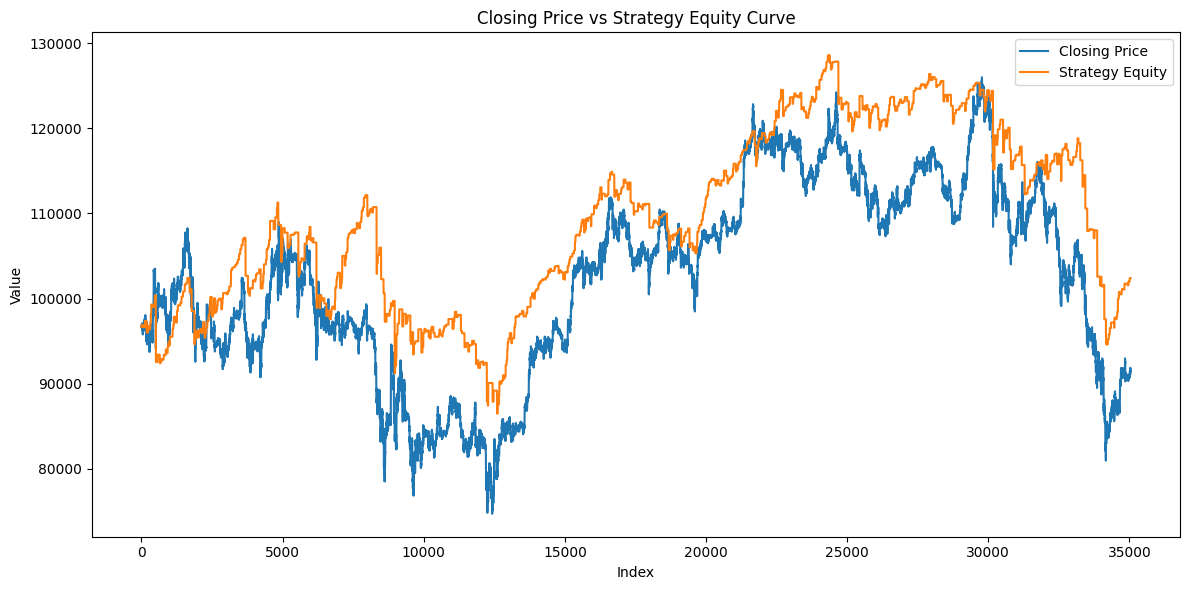

In [884]:
plot_equity_vs_price(df)

#### Strategy metrics

In [885]:
def extract_trades(df):
    """
    Extract all trades from the position column.
    Records:
        - entry_time
        - exit_time
        - entry_price
        - exit_price
        - return
    Computes:
        - number of wins
        - number of losses
        - win rate
    """
    df = df.copy()

    trades = []
    entry_time = None
    entry_price = None

    for i in range(1, len(df)):
        pos_prev = df['position'].iloc[i-1]
        pos_now  = df['position'].iloc[i]
        price_now = df['Close'].iloc[i]
        time_now  = df.index[i]

        # ENTRY
        if pos_prev == 0 and pos_now == 1:
            entry_time = time_now
            entry_price = price_now

        # EXIT
        elif pos_prev == 1 and pos_now == 0:
            exit_time = time_now
            exit_price = price_now
            ret = (exit_price - entry_price) / entry_price

            trades.append({
                "entry_time": entry_time,
                "exit_time": exit_time,
                "entry_price": entry_price,
                "exit_price": exit_price,
                "return": ret
            })

            entry_time = None
            entry_price = None

    trades_df = pd.DataFrame(trades)

    # --- Win/Loss statistics ---
    if len(trades_df) > 0:
        wins = trades_df[trades_df['return'] > 0].shape[0]
        losses = trades_df[trades_df['return'] <= 0].shape[0]
        win_rate = wins / len(trades_df)
    else:
        wins = losses = 0
        win_rate = None

    stats = {
        "num_trades": len(trades_df),
        "wins": wins,
        "losses": losses,
        "win_rate": win_rate
    }

    return trades_df, stats


In [886]:
trades_df, stats = extract_trades(df)

print(trades_df.head())
print(stats)


                        entry_time                        exit_time  \
0 2024-11-30 15:44:59.999000+00:00 2024-11-30 16:59:59.999000+00:00   
1 2024-11-30 21:59:59.999000+00:00 2024-12-01 04:59:59.999000+00:00   
2 2024-12-01 19:44:59.999000+00:00 2024-12-01 21:59:59.999000+00:00   
3 2024-12-02 03:44:59.999000+00:00 2024-12-02 13:29:59.999000+00:00   
4 2024-12-02 17:29:59.999000+00:00 2024-12-03 02:44:59.999000+00:00   

   entry_price  exit_price    return  
0     96634.28    96871.31  0.002453  
1     96792.02    96515.52 -0.002857  
2     97023.31    97767.62  0.007671  
3     97042.10    95690.65 -0.013926  
4     95372.73    96144.00  0.008087  
{'num_trades': 782, 'wins': 524, 'losses': 258, 'win_rate': 0.670076726342711}


In [887]:
df

,open,high,low,close,volume,Close,support,resistance,entry_raw,exit_raw,close_log_return_lag_3,position,entry_price,exit_price,equity,cumulative_return
close_time,,,,,,,,,,,,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453,96659.50,NaN,NaN,False,False,0.000000,0,NaN,NaN,96659.500000,0.000000
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398,96634.28,96659.50,96659.50,True,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427,96645.41,96634.28,96659.50,False,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529,96652.01,96634.28,96659.50,False,False,0.000000,1,96634.28,NaN,96659.500000,0.000000
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,96555.42,96634.28,96659.50,True,False,-0.000261,1,96634.28,NaN,96659.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,91682.73,91048.78,91851.19,False,False,0.004175,0,NaN,NaN,102400.775549,0.059397
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,91554.20,91048.78,91851.19,False,False,-0.001771,0,NaN,NaN,102400.775549,0.059397
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,91359.92,91048.78,91851.19,False,False,0.000886,0,NaN,NaN,102400.775549,0.059397


#### Diagnostics